<a href="https://colab.research.google.com/github/Waleed-Mujahid/Fast-Gradient-Sign-method/blob/main/adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks against Neural Networks
In the past few years Artificial Inteligence has taken over the world. We see AI-driven systems everywhere. From face recognition systems to self-driven cars AI has become essential to our everyday lives. At the heart of AI are neural networks. Neural networks have the ability to learn patterns from data and then make decisions on unseen data without human interference.

---

But these neural networks are susceptible to attacks. As shown in in the paper "Intruiging properties of Neural Networks" by [Szegedy et al]. They showed by ading some targeted noise to an input we can make a neural network misclassify it. This is a great security concern as these attacks can lead to an accident in case of self-driven cars or leaking some sensitive information by giving access to some unauthorized person.

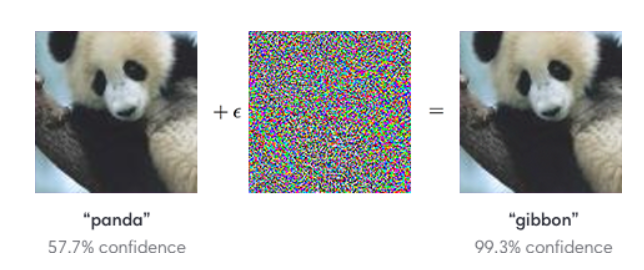

In the above image we can see the neural network was classifying the image correctly but after the addition of some targeted noise the neural network makes wrong prediction, that too with a very high confidence interval.
One thing to note here is that the orignal image and the adversarial image are indistinguishable for the human eye.


In this notebook I generate adversarial images using the fast gradient sign method introduced in *"Explaining and Harnessing Adversarial Examples"* by [Goodfellow et al]. 


---

I have taken a tiny version of the Food-101 dataset with 10 classes with 200 images each (150 training and 50 test images).
I use a pre-trained Movilenet-V2 model to train on the dataset. Then I use the Fast gradient sign method to generate adversial images to fool the classifier.

## Import Dependecies

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras 
from keras import Sequential
from keras.layers import Dense, Conv2D, InputLayer, MaxPooling2D, Flatten, Input,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

here I import some helper functions

In [2]:
!wget https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py

--2022-08-05 08:29:06--  https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2206 (2.2K) [text/plain]
Saving to: ‘colabUtils.py’

colabUtils.py       100%[===================>]   2.15K  --.-KB/s    in 0s      

2022-08-05 08:29:07 (28.4 MB/s) - ‘colabUtils.py’ saved [2206/2206]



In [3]:
import colabUtils as utils

## Loading our dataset from kaggle

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! mkdir ~/.kaggle

First you need to download your API credentials from kaggle. You will get a kaggle.json file. Upload it below

In [6]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d msarmi9/food101tiny

 68% 65.0M/96.1M [00:00<00:00, 100MB/s] 
100% 96.1M/96.1M [00:00<00:00, 117MB/s]


In [9]:
!unzip -q /content/food101tiny.zip

## Visualizing our Dataset
Now lets use one of the helper functions to visualize the data.

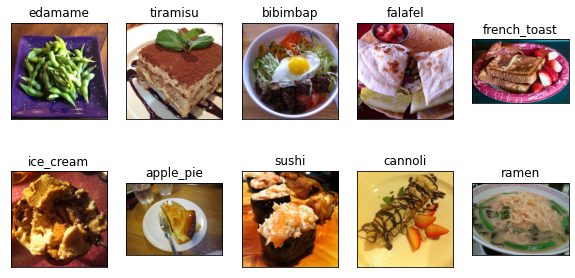

In [10]:
utils.visualizeData('/content/data/food-101-tiny/train', (2,5))

As the images in the dataset do not have the same size so we need to bring them to the same size. We can do this with ImageDataGenerator from keras. We can also use it to augment.

In [11]:
image_shape = (224,224)

In [12]:
train_datagen = ImageDataGenerator( 
    rescale = 1/255.,
    rotation_range = 20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [13]:
train_dir = '/content/data/food-101-tiny/train'
test_dir = '/content/data/food-101-tiny/valid'

In [14]:
num_classes = len(os.listdir(train_dir))

In [15]:
train_generator = train_datagen.flow_from_directory(train_dir,batch_size = 32, target_size = image_shape)
validation_generator = test_datagen.flow_from_directory(test_dir,batch_size = 32, target_size = image_shape)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## Transfer Learning
Next we take a Efficient-B0 trained on imagenet and fine tune it to our dataset.

In [16]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
model = Sequential()
model.add(base_model)

# next we add some layers of our own
model.add(Conv2D(128, (5, 5), padding = 'same'))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(128, (5, 5), padding = 'same' ))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), padding = 'same'))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(256, (3, 3), padding = 'same' ))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         4096128   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         409728    
                                                                 
 activation_1 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                      

In [18]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
metrics=['accuracy'])

In [19]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode = 'min',
    verbose=1,
    patience = 5,
    restore_best_weights=True,
)

In [20]:
history = model.fit(train_generator, batch_size = 32, epochs = 30, validation_data = validation_generator, callbacks = [es], verbose = 1)

Epoch 1/30
47/47 [==============================] - 43s 504ms/step - loss: 2.4391 - accuracy: 0.1267 - val_loss: 2.1766 - val_accuracy: 0.3000
Epoch 2/30
47/47 [==============================] - 23s 497ms/step - loss: 2.1637 - accuracy: 0.2107 - val_loss: 1.9432 - val_accuracy: 0.4020
Epoch 3/30
47/47 [==============================] - 23s 477ms/step - loss: 1.9150 - accuracy: 0.3007 - val_loss: 1.6298 - val_accuracy: 0.5640
Epoch 4/30
47/47 [==============================] - 22s 470ms/step - loss: 1.6720 - accuracy: 0.3933 - val_loss: 1.3430 - val_accuracy: 0.5980
Epoch 5/30
47/47 [==============================] - 22s 472ms/step - loss: 1.4548 - accuracy: 0.4507 - val_loss: 1.1421 - val_accuracy: 0.6880
Epoch 6/30
47/47 [==============================] - 24s 507ms/step - loss: 1.2255 - accuracy: 0.5540 - val_loss: 0.9188 - val_accuracy: 0.7420
Epoch 7/30
47/47 [==============================] - 22s 474ms/step - loss: 1.0344 - accuracy: 0.6440 - val_loss: 0.8142 - val_accuracy: 0.7480

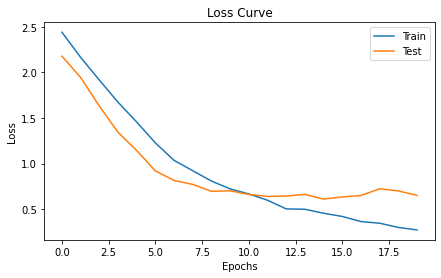

In [21]:
utils.plotLoss(history,True)

Now lets have a look at our model's performance.

In [22]:
loss, accuracy_nn = model.evaluate(validation_generator)
print(f"The accuracy received on Test data is: {accuracy_nn*100:.2f}%")

16/16 [==============================] - 2s 142ms/step - loss: 0.6097 - accuracy: 0.7960
The accuracy received on Test data is: 79.60%


# Fast Gradient sign method
Now we make the implementation of the fast gradient sign method.


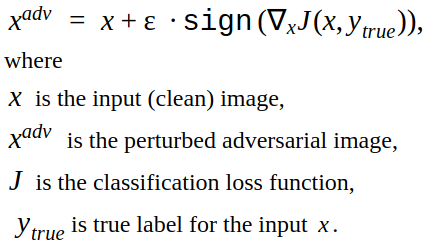

In [23]:
def fgsm(input_img, model, eps, loss_fn, y_true):
  input_img = tf.expand_dims(input_img, axis = 0)
  y_true = tf.one_hot(y_true,10)
  y_true = tf.reshape(y_true, (1, 10))

  with tf.GradientTape() as tape:
    tape.watch(input_img)
    logit = model(input_img)
    loss = loss_fn(y_true,logit) # loss/ cost between true label versus predicted label

  grad = tape.gradient(loss,input_img) # Derivative of the loss with respect to the orignal image
  perturbation = tf.sign(grad)
  adv_img = input_img + eps * perturbation
  adv_img = np.clip(adv_img, 0, 1)
  adv_img = tf.squeeze(adv_img, axis = 0)
  return adv_img

## Visualizing Orignal and Adversial images
Let us compare the adversial images and orignal images side by side.

In [24]:
name_labels = validation_generator.class_indices
index_labels = {value:key for key, value in name_labels.items()}

In [25]:
parent_dir = '/content/data/food-101-tiny/train'
paths = []
lab = []

for dir in os.listdir(parent_dir):
  p_dir = parent_dir + '/' + dir
  paths.append(p_dir + '/' + random.choice(os.listdir(p_dir)))
  lab.append(dir)

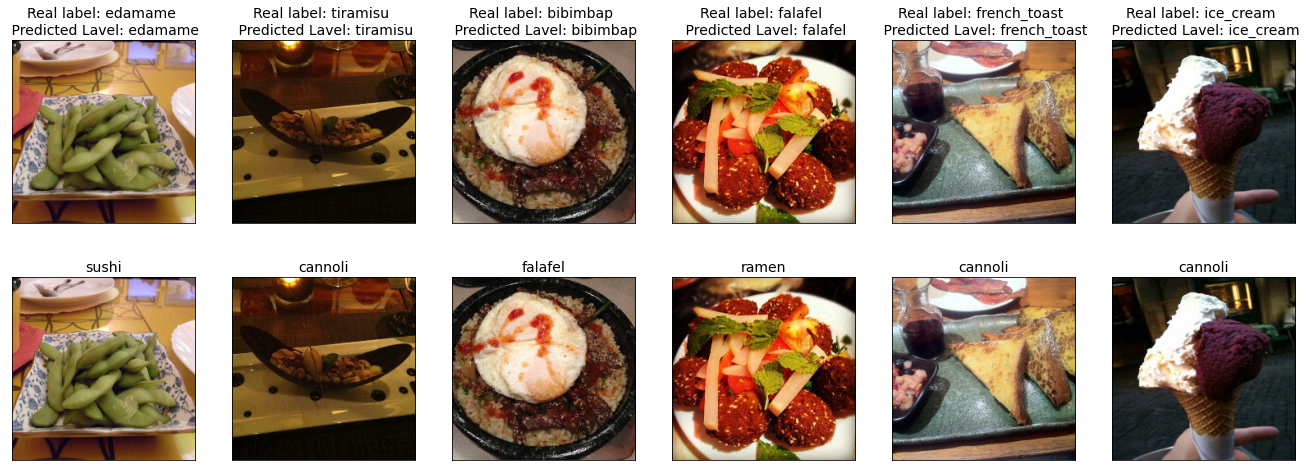

In [38]:
count = 1
epsilon = 0.01
loss = tf.keras.losses.categorical_crossentropy

plt.figure(figsize = (23,8))
for i in range(6):
  image = utils.processImg(paths[i], image_shape)
  plt.subplot(2,6,count)
  plt.imshow(image)
  plt.xticks([])             # Disabling ticks
  plt.yticks([])
  pred = model.predict(tf.expand_dims(image, axis = 0))
  pred_class = index_labels[pred.argmax()]
  plt.title(f"Real label: {lab[i]} \n Predicted Lavel: {pred_class}", fontsize = 14)

  adv_img = fgsm(image,model,epsilon,loss, name_labels[lab[i]])
  plt.subplot(2,6,count+6)
  plt.imshow(adv_img)
  plt.xticks([])         
  plt.yticks([])
  pred = model.predict(tf.expand_dims(adv_img, axis = 0 ))
  pred_class = index_labels[pred.argmax()]
  plt.title(pred_class, fontsize = 14)
  count += 1

## Fooling the model on Test set
Now we add perturbation generated using FGSM and add it to Test dataset to checks how much accuracy falls.


In [27]:
file_path = '/content/data/food-101-tiny/valid'
label = []
data = []
adv_pred = []
adv_x = []
epsilon = 0.05
labels = validation_generator.class_indices
loss = tf.keras.losses.categorical_crossentropy

for dir in os.listdir(file_path):
  label_val = labels[dir]
  img_path = os.path.join(file_path, dir)
  for img in os.listdir(img_path):
    path = os.path.join(img_path, img)
    image = utils.processImg(path, image_shape)
    data.append(image)    
    label.append(label_val)
    adv_img = fgsm(image, model, epsilon, loss, label_val)
    adv_x.append(adv_img)
    adv_img = tf.expand_dims(adv_img, axis = 0)

In [28]:
data = np.asarray(data)
label = np.asarray(label)
adv_x = np.asarray(adv_x)
print(adv_x.shape)

(500, 224, 224, 3)


In [29]:
ssim = tf.reduce_mean(tf.image.ssim(data,adv_x,1))
print(f'The adversarial examples we have generated have a similarity index of {ssim:.2f}')

The adversarial examples we have generated have a similarity index of 0.64


In [39]:
from sklearn.metrics import accuracy_score

def eval(classifier, label, clean_data, adv_data):
  pred = classifier.predict_on_batch(clean_data)
  pred = np.argmax(pred,axis=1)
  adv_pred = classifier.predict_on_batch(adv_data)
  adv_pred = np.argmax(adv_pred, axis = 1)

  accuracy = accuracy_score(label,pred)
  adversial_batch_accuracy = accuracy_score(label,adv_pred)
  print(f'Accuracy of classifier on clean test set = {accuracy*100:.2f}')
  print(f'Accuracy of classifier on test set after adding perturbation = {adversial_batch_accuracy*100:.2f}')

  n_samples = pred.shape[0]
  corrects = np.sum(adv_pred == pred)
  fool_rate = (n_samples-corrects)/n_samples
  print(f'So {fool_rate*100:.2f} % examples changed their orignal prediction after adding perturbation.')

In [40]:
eval(model, label, data, adv_x)

Accuracy of classifier on clean test set = 79.20
Accuracy of classifier on test set after adding perturbation = 7.20
So 77.20 % examples changed their orignal prediction after adding perturbation.


So we can see from the above plot that there is very minimal differnece between the orignal images and the adversial images. Stil, the accuracy of the classifier dropped from 79.2% to 7.2%. This is the power of adverisal attacks.

# Checking the transferability of Adversarial Examples
Next we train another model with a different architecture on the dataset. Then we will try to fool this newer model with the adversarial images generated from the orignal model.


---

Next we will train the dataset on InceptionV3

In [32]:
from tensorflow.keras.applications import InceptionV3
base_model2 = InceptionV3(weights='imagenet', input_shape=(224,224,3), include_top=False)
base_model2.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [33]:
model2 = Sequential()
model2.add(base_model2)

# next we add some layers of our own
model2.add(Conv2D(128, (5, 5), padding = 'same'))
model2.add(keras.layers.Activation('relu'))
model2.add(Conv2D(128, (5, 5), padding = 'same' ))
model2.add(keras.layers.Activation('relu'))
model2.add(MaxPooling2D(strides=2))
model2.add(Dropout(0.5))

model2.add(Conv2D(256, (3, 3), padding = 'same'))
model2.add(keras.layers.Activation('relu'))
model2.add(Conv2D(256, (3, 3), padding = 'same' ))
model2.add(keras.layers.Activation('relu'))
model2.add(MaxPooling2D(strides=2))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(num_classes,activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_98 (Conv2D)          (None, 5, 5, 128)         6553728   
                                                                 
 activation_98 (Activation)  (None, 5, 5, 128)         0         
                                                                 
 conv2d_99 (Conv2D)          (None, 5, 5, 128)         409728    
                                                                 
 activation_99 (Activation)  (None, 5, 5, 128)         0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                      

In [34]:
model2.compile(loss=tf.keras.losses.categorical_crossentropy,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
metrics=['accuracy'])

In [35]:
history = model2.fit(train_generator, batch_size = 32, epochs = 40, validation_data = validation_generator, callbacks = [es], verbose = 1)

Epoch 1/40
47/47 [==============================] - 32s 560ms/step - loss: 2.3727 - accuracy: 0.1133 - val_loss: 2.2674 - val_accuracy: 0.2040
Epoch 2/40
47/47 [==============================] - 23s 490ms/step - loss: 2.2890 - accuracy: 0.1387 - val_loss: 2.2285 - val_accuracy: 0.3040
Epoch 3/40
47/47 [==============================] - 25s 531ms/step - loss: 2.2377 - accuracy: 0.1613 - val_loss: 2.1487 - val_accuracy: 0.4240
Epoch 4/40
47/47 [==============================] - 27s 568ms/step - loss: 2.1817 - accuracy: 0.2160 - val_loss: 2.0213 - val_accuracy: 0.4200
Epoch 5/40
47/47 [==============================] - 23s 487ms/step - loss: 2.0740 - accuracy: 0.2593 - val_loss: 1.8575 - val_accuracy: 0.5020
Epoch 6/40
47/47 [==============================] - 23s 489ms/step - loss: 1.9513 - accuracy: 0.3240 - val_loss: 1.6937 - val_accuracy: 0.5040
Epoch 7/40
47/47 [==============================] - 23s 487ms/step - loss: 1.8118 - accuracy: 0.3787 - val_loss: 1.5422 - val_accuracy: 0.5280

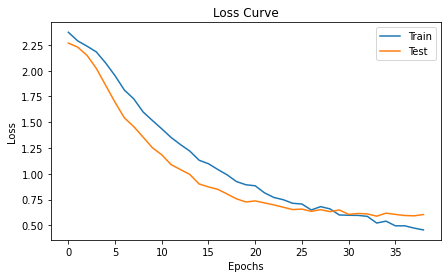

In [36]:
utils.plotLoss(history,True)

In [41]:
eval(model2, label, data, adv_x)

Accuracy of classifier on clean test set = 81.40
Accuracy of classifier on test set after adding perturbation = 49.00
So 43.60 % examples changed their orignal prediction after adding perturbation.


This is an example of a black box attack. Where we used adversarial examples generated from one neural network on another one. It is called black box because we did not have any information about the neural network being attacked's archeitecture. Still we wereable to reduce the accuracy of the neural network from 81.4% to 49%. We can drop the accuracy even further by using stronger adversarial examples. But that will make the noise visible to naked eye. So we have a trade off.